In [1]:
import numpy as np
import scipy.io as io
import sigpy as sp
import matplotlib.pyplot as plt
from csaps import csaps # pip install -U csaps, this is for spline smoothing
from skimage.data import shepp_logan_phantom
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale, resize, downscale_local_mean

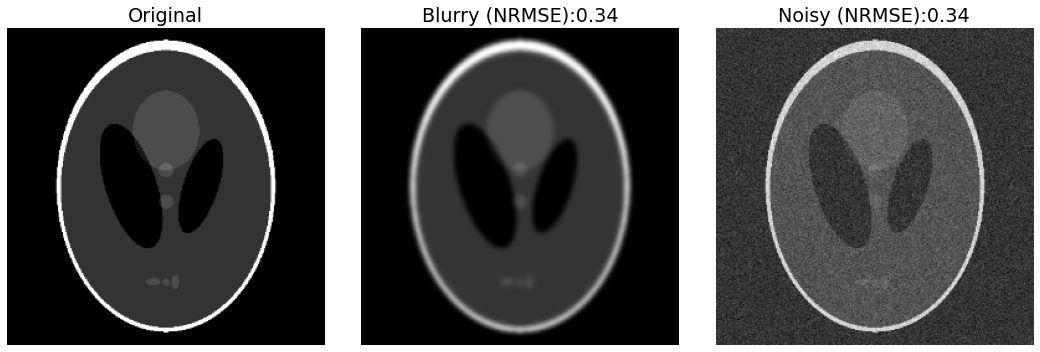

In [8]:
image = shepp_logan_phantom() 
image = resize(image,[256,256])
image_blur = gaussian_filter(image, 2)

nrmse = np.linalg.norm(image - image_blur) / np.linalg.norm(image) 

noise = np.random.normal(0, 1, image.shape)
noise = noise * nrmse / np.linalg.norm(noise) * np.linalg.norm(image)
image_noisy = image + noise

nrmse2 = np.linalg.norm(image - image_noisy) / np.linalg.norm(image) 

plt.rcParams['font.size'] = '16'
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(15,5))
ax1.imshow(image,cmap='gray')
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(image_blur,cmap='gray')
ax2.axis('off')
ax2.set_title('Blurry (NRMSE):{}'.format(np.round(nrmse,2)))
ax3.imshow(image_noisy,cmap='gray')
ax3.axis('off')
ax3.set_title('Noisy (NRMSE):{}'.format(np.round(nrmse2,2)))
fig.tight_layout()


In [5]:
# Compute Fourier representation
def esp(im_mov, im_ref, smooth = 0.999):
    ksp_vn = sp.fft(im_mov, axes=(0,1))
    ksp_full = sp.fft(im_ref, axes=(0,1))

    # Radial Grid
    X = np.linspace(1,ksp_vn.shape[0],ksp_vn.shape[0])
    Y = np.linspace(1,ksp_vn.shape[1],ksp_vn.shape[1])

    xgrid, ygrid = np.meshgrid(X,Y)
    center_x, center_y = ksp_vn.shape[0] // 2 + 1, ksp_vn.shape[1] // 2 + 1

    xgrid = xgrid - center_x
    ygrid = ygrid - center_y
    
    xgrid = np.transpose(xgrid)
    ygrid = np.transpose(ygrid)
    r = (xgrid ** 2 + ygrid ** 2) ** 0.5
    r = np.floor((r * 1e10) / 1e10)
    k_err = np.abs(ksp_vn - ksp_full) ** 2
    k_true = np.abs(ksp_full) ** 2

    
    r = np.ndarray.flatten(r)
    k_err = np.ndarray.flatten(k_err)
    k_true = np.ndarray.flatten(k_true)
    
    rr, idx = np.unique(r, return_inverse=True)
    
    k_err_avg = np.zeros(rr.shape)
    k_true_avg = np.zeros(rr.shape)

    repeated_r_count = np.zeros(rr.shape)
    for ii, yy in enumerate(idx):
        repeated_r_count[yy] += 1    
        k_err_avg[yy] += k_err[ii]
        k_true_avg[yy] += k_true[ii]
        
    k_err_avg = k_err_avg / repeated_r_count
    k_true_avg = k_true_avg / repeated_r_count
    
    y = np.stack((k_err_avg, k_true_avg), axis=1) # stack

    xi = np.linspace(0, r.max() * 0.85, 100) # gridding points
    yi = csaps(rr, y, xi, smooth=smooth, axis=0)
    err_plot = yi[:,0]
    true_plot = yi[:,1]
    err_fraction = np.real(np.sqrt(err_plot/true_plot))

    return xi, err_fraction

<ipython-input-5-e694be5b79f9>:48: RuntimeWarning: invalid value encountered in sqrt
  err_fraction = np.real(np.sqrt(err_plot/true_plot))


Text(0.5, 0, 'Spatial Frequency (Nyquist units)')

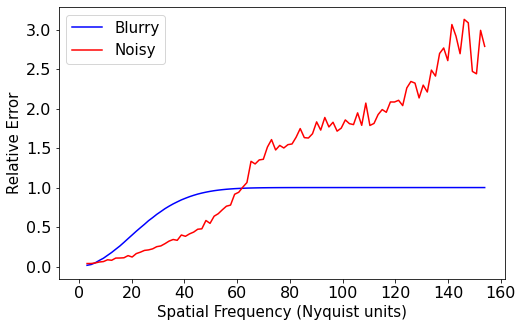

In [6]:
xi, err1 = esp(image_blur,image, smooth=0.999)
xi, err2 = esp(image_noisy,image, smooth=0.999)

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,5))
plt.plot(xi,err1,'b',xi,err2,'r')
plt.legend(['Blurry','Noisy'],fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.xlabel('Spatial Frequency (Nyquist units)',fontsize=15)